<a href="https://colab.research.google.com/github/edrian-liao/harvestnet/blob/main/notebooks/HarvestNet_Evaluate_Model_Subdivisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -qU
!pip install torchmetrics -qU
!pip install accelerate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.0 MB/s eta 0:00:00


In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision
import wandb
import numpy as np
from torchmetrics import Accuracy, F1Score, AUROC, Precision, Recall
from accelerate import Accelerator
from collections import defaultdict
import cv2

In [3]:
from tools.dataset import SkysatLabelled
from tools.config import Config_Resnet

In [4]:
# -----------------
# CONFIG
# -----------------

config = Config_Resnet()


# Seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)


accelerator = Accelerator(
    log_with="wandb",
    mixed_precision=config.mixed_precision,
)
device = accelerator.device

# Log on each process the small summary:
if accelerator.is_main_process:
    print(f"Training/evaluation parameters:")
    print(config.__dict__)

accelerator.init_trackers(
    config.wandb_project,
    config=config,
    init_kwargs={
        "wandb": {
            "group": config.wandb_group,
            "reinit": True,
            "dir": os.path.join(config.working_dir),
        }
    },
)

LOGGING = True
if LOGGING:
    accelerator.init_trackers(
        config.wandb_project,
        config=config,
        init_kwargs={
            "wandb": {
                "group": config.wandb_group,
                "reinit": True,
                "dir": os.path.join(config.working_dir),
            }
        },
    )


# -----------------
# DATASET
# -----------------
if accelerator.is_main_process:
    print("Loading datasets")
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.412, 0.368, 0.326], std=[0.110, 0.097, 0.098]
        ),  # our dataset vals
    ]
)

Training/evaluation parameters:
{'working_dir': 'harvest-piles', 'dataset_path': 'dataset', 'wandb_project': 'harvest-piles', 'wandb_group': 'resnet50', 'seed': 2023, 'scheduler': 'one_cycle_lr', 'lr': 0.001, 'optimizer': 'madgrad', 'mixed_precision': 'fp16', 'num_train_epochs': 30, 'batch_size': 32}


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Path harvest-piles/wandb/ wasn't writable, using system temp directory.


Loading datasets


In [5]:
test_dataset = SkysatLabelled(
    os.path.join(config.dataset_path, "dummy_test.csv"),
    os.path.join(config.dataset_path, "patch_images"),
    transform,
)

In [20]:
test_dataset[13]

(tensor([[[ 1.9943,  2.2795,  2.5647,  ...,  1.5665,  2.0656,  2.5647],
          [ 2.1369,  2.3508,  2.5647,  ...,  2.0299,  2.3508,  2.7430],
          [ 2.2439,  2.3508,  2.4934,  ...,  2.4578,  2.7073,  2.9569],
          ...,
          [ 1.0674,  1.3526,  1.5665,  ..., -1.6777, -1.6064, -1.6064],
          [ 1.0674,  1.3882,  1.7447,  ..., -1.8560, -1.7847, -1.6421],
          [ 1.1387,  1.3526,  1.7447,  ..., -1.8560, -1.9629, -1.7847]],
 
         [[ 2.0683,  2.4322,  2.7556,  ...,  1.4215,  2.0683,  2.6748],
          [ 2.1492,  2.4726,  2.7556,  ...,  2.0279,  2.4322,  2.9173],
          [ 2.3513,  2.4726,  2.6748,  ...,  2.5535,  2.8365,  3.1195],
          ...,
          [ 1.0172,  1.4215,  1.6640,  ..., -2.4192, -2.3384, -2.3384],
          [ 1.0576,  1.4619,  1.8662,  ..., -2.7022, -2.9448, -2.8235],
          [ 1.0172,  1.3406,  1.8258,  ..., -2.7427, -3.4704, -3.3087]],
 
         [[ 1.5154,  1.9156,  2.3157,  ...,  0.9952,  1.6755,  2.3157],
          [ 1.7555,  2.1557,

In [21]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

In [22]:
class ResNet50(torch.nn.Module):
    def __init__(self, num_classes, model_weights_path):
        super(ResNet50, self).__init__()
        self.resnet50 = torchvision.models.resnet50()
        num_features = self.resnet50.fc.out_features
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_classes),
            torch.nn.Sigmoid(),
        )
        # Load the state dictionary
        state_dict = torch.load(model_weights_path)
        # Assign the loaded state dictionary to the model
        self.load_state_dict(state_dict)

    def forward(self, x):
        logits = self.resnet50(x)
        return self.fc(logits)

# Example usage:
num_classes = 1  # Number of output classes
model_weights_path = 'best_resnet.pt'
model = ResNet50(num_classes, model_weights_path)

In [26]:
from osgeo import gdal

In [27]:
def load_geotiff(file):
    ds = gdal.Open(file)
    band1 = ds.GetRasterBand(1).ReadAsArray() # Red channel
    band2 = ds.GetRasterBand(2).ReadAsArray() # Green channel
    band3 = ds.GetRasterBand(3).ReadAsArray() # Blue channel
    img = np.dstack((band1, band2, band3))
    return img

In [24]:
# -----------------
# OPTIMIZER, SCHEDULER
# -----------------
criterion = torch.nn.BCELoss()

accuracy = Accuracy(task="binary")
f1_score = F1Score(task="binary")
auroc = AUROC(task="binary")
precision = Precision(task="binary")
recall = Recall(task="binary")

# -----------------
# ACCELERATOR
# -----------------
model, test_dataloader = accelerator.prepare(model, test_dataloader)
accuracy, f1_score, auroc, precision, recall = accelerator.prepare(
    accuracy, f1_score, auroc, precision, recall
)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    sum_metrics = defaultdict(float)

    model.eval()

    with torch.no_grad():
        for x, y, _ in iterator:
            pred = model(x)
            print(y, pred)
            loss = criterion(pred, y)
            evals = {
                "acc": accuracy(pred, y),
                "f1": f1_score(pred, y),
                "auroc": auroc(pred, y),
                "precision": precision(pred, y),
                "recall": recall(pred, y),
            }
            for k, v in evals.items():
                sum_metrics[k] += v

            epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    avg_metrics = {k: v / len(iterator) for k, v in sum_metrics.items()}
    # print("Test: ", avg_metrics)

    return epoch_loss, avg_metrics

valid_loss, val_metrics = evaluate(model, test_dataloader, criterion)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0') tensor([[1.0000e+00],
        [1.2451e-01],
        [6.2408e-03],
        [7.2594e-03],
        [5.7755e-03],
        [4.7684e-07],
        [8.5352e-01],
        [1.0000e+00],
        [7.0143e-04],
        [1.4305e-06],
        [3.9160e-05],
        [5.1384e-03],
        [3.5763e-07],
        [2.3842e-07],
        [7.0333e-05],
        [3.9935e-06]], device='cuda:0')


Here, we can see that the fourth image was classified correctly as a positive. Let us check what it looks like along with the rest of the patches.

In [30]:
path = "dataset/patch_images/396_4.tif"
image = load_geotiff(path)

array([[[79, 71, 57],
        [81, 74, 60],
        [86, 79, 67],
        ...,
        [87, 88, 77],
        [89, 89, 79],
        [90, 90, 80]],

       [[81, 74, 61],
        [83, 76, 63],
        [87, 80, 69],
        ...,
        [88, 89, 78],
        [89, 90, 80],
        [90, 91, 81]],

       [[85, 79, 68],
        [86, 80, 69],
        [89, 83, 71],
        ...,
        [89, 90, 79],
        [90, 91, 81],
        [91, 92, 82]],

       ...,

       [[76, 94, 75],
        [77, 94, 75],
        [78, 95, 75],
        ...,
        [94, 91, 77],
        [91, 88, 73],
        [90, 86, 71]],

       [[80, 97, 76],
        [80, 97, 76],
        [82, 97, 76],
        ...,
        [92, 88, 74],
        [90, 85, 71],
        [89, 84, 69]],

       [[82, 98, 77],
        [82, 98, 77],
        [83, 98, 76],
        ...,
        [92, 87, 73],
        [89, 84, 70],
        [88, 83, 68]]], dtype=uint8)
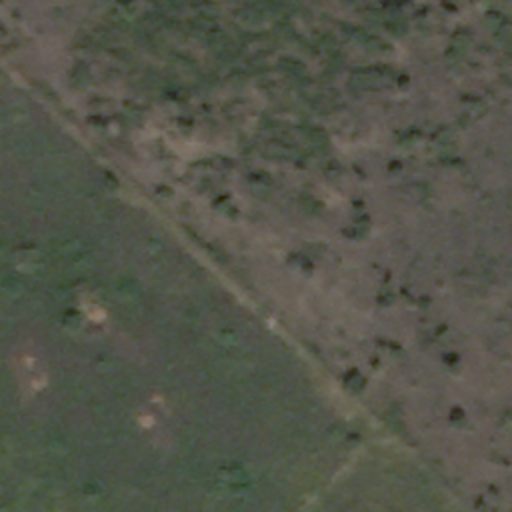

In [31]:
image